# Installation and Import 

In [40]:
# Import common libraries
import pandas as pd 
import boto3
import numpy as np
from sklearn.model_selection import train_test_split

## DataFrame Manipulation

In [41]:
# Visualize the data
df = pd.read_csv("paysim/paysim_cleaned.csv")
df.head(5)

,isFraud,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,181.00,181.0,0.0,0.0,0.00
1,1,181.00,181.0,0.0,21182.0,0.00
2,0,229133.94,15325.0,0.0,5083.0,51513.44
3,0,215310.30,705.0,0.0,22425.0,0.00
4,0,311685.89,10835.0,0.0,6267.0,2719172.89


# Preprocessing 

In [42]:
X = df.drop(["isFraud"], axis=1)
y = df["isFraud"]

# Create a Train Test and Valid Split 
X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [43]:
X_train.shape, y_train.shape, X_valid.shape

((1994694, 5), (1994694,), (277041, 5))

In [44]:
X_train.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2182289,434304.56,107970.0,0.0,1231539.88,1665844.44
1030605,103123.43,157.0,0.0,69206.70,172330.13
1368608,29168.63,12183.0,0.0,792536.46,821705.09
1413690,199046.52,29767.0,0.0,0.00,199046.52
2275047,151700.26,0.0,0.0,3046008.00,3197708.26


In [6]:
# Simple Preprocessing Pipeline 
from sklearn.preprocessing import StandardScaler

# Remove NaN that numeric
def remove_numeric_missing_values(df):
    filled_df = df.fillna(df.median())
    return filled_df

# Remove NaN that are of type string
def remove_string_missing_values(df):
    filled_df = df.fillna("unknown")
    return filled_df 

# Create dummy variables
def dummyfication(df):
    dummy_df=pd.get_dummies(df, drop_first=True)
    return dummy_df

# Normalize
def normalize(df, standard_scaler):
    normalized_df = standard_scaler.transform(df)
    return normalized_df 

# Fit it all into one pipeline
def preprocessing_pipeline(df, target, standard_scaler, *args):
    df = df.drop(columns=[col for col in args]) # Drop useless columns 
    df = remove_numeric_missing_values(df)
    df = remove_string_missing_values(df)
    df = dummyfication(df)
    columns = ['target']
    columns.extend(df.columns)
    df = normalize(df, standard_scaler)
    df = np.hstack((target.values.reshape(-1,1), df))
    df = pd.DataFrame(data=df, columns=columns)
    return df 

In [7]:
# Creating a Train set
sc_X = StandardScaler()
sc_X.fit(X_train)

train_set = preprocessing_pipeline(X_train, y_train, sc_X)
train_set.head()

,target,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.0,-0.043675,-0.190379,-0.107734,-0.179387,-0.176367
1,0.0,-0.262365,-0.147164,-0.107734,-0.387670,-0.405873
2,0.0,-0.354906,-0.030684,0.145319,-0.402993,-0.437261
3,0.0,0.004390,-0.053684,-0.107734,0.092818,0.078470
4,0.0,-0.191311,-0.190379,-0.107734,-0.198605,-0.221725


In [8]:
# Creating a Test set
test_set = preprocessing_pipeline(X_test, y_test, sc_X)
test_set.head()

,target,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.0,-0.048917,-0.102703,-0.107734,-0.085507,-0.092617
1,1.0,0.068086,1.325618,-0.107734,-0.402993,-0.357013
2,0.0,-0.341812,-0.190379,-0.107734,0.003569,-0.067775
3,0.0,-0.013115,-0.119458,-0.107734,1.820381,1.634614
4,0.0,-0.204291,-0.175095,-0.107734,-0.402993,-0.408687


In [9]:
valid_set = preprocessing_pipeline(X_valid, y_valid, sc_X)
valid_set.head()

,target,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.0,-0.086573,-0.190379,-0.107734,-0.180990,-0.185953
1,0.0,-0.157908,-0.150636,-0.107734,-0.402993,-0.399888
2,0.0,-0.355925,-0.190379,-0.107734,-0.137680,-0.197958
3,0.0,0.261368,-0.190379,-0.107734,-0.158454,-0.099600
4,0.0,-0.225232,-0.190379,-0.107734,-0.353205,-0.367717


## File upload 

In [10]:
# Create two CSV files that we will upload to S3
train_file = train_set.to_csv("paysim/paysim-train-set.csv", index=False, header=False)
test_file = test_set.to_csv("paysim/paysim-test-set.csv", index=False, header=False)
valid_file = valid_set.to_csv("paysim/paysim-valid-set.csv", index=False, header=False)

In [45]:
# Create a boto3 session with AWS Credentials
aws_session = boto3.Session(
    region_name="eu-west-1"
)
s3 = aws_session.client("s3")

In [46]:
BUCKET_NAME = "lead-s2-paysim"
PREFIX = "model"

In [13]:
# Upload training ,testing and valid set to an S3 Bucket
s3.put_object(
    Body=open("paysim/paysim-train-set.csv").read(),
    Bucket="lead-s2-paysim",
    Key="model/train/paysim-train.csv"
)

s3.put_object(
    Body=open("paysim/paysim-test-set.csv").read(),
    Bucket="lead-s2-paysim",
    Key="model/test/paysim-test.csv"
)

s3.put_object(
    Body=open("paysim/paysim-valid-set.csv").read(),
    Bucket=BUCKET_NAME,
    Key="model/valid/paysim-valid.csv"
)

{'ResponseMetadata': {'RequestId': '39A27921A367BECC',
  'HostId': 'o+45bO+3w+xCazZTmENKsvJJey/GPFWYQ0y3lI2BcxkzfBdmSj3lf8Yk9ewofr/X993JfVgRA5o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'o+45bO+3w+xCazZTmENKsvJJey/GPFWYQ0y3lI2BcxkzfBdmSj3lf8Yk9ewofr/X993JfVgRA5o=',
   'x-amz-request-id': '39A27921A367BECC',
   'date': 'Fri, 25 Sep 2020 07:02:02 GMT',
   'etag': '"f14fa89ee289b727e8c103af040af6a5"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"f14fa89ee289b727e8c103af040af6a5"'}

## Import models

In [47]:
# Import SageMaker and a container with a XGBoost image
import sagemaker 
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(aws_session.region_name, "xgboost", repo_version="1.0-1")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [15]:
container

'141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

In [48]:
# Set variables for our Bucket URI
train_data = 's3://{}/{}/{}'.format(BUCKET_NAME, PREFIX, 'train')

test_data = 's3://{}/{}/{}'.format(BUCKET_NAME, PREFIX, 'test')

validation_data = 's3://{}/{}/{}'.format(BUCKET_NAME, PREFIX, 'valid')

s3_output_location = 's3://{}/{}/{}'.format(BUCKET_NAME, PREFIX, 'xgboost_model_sdk')

print(train_data, test_data, validation_data)

s3://lead-s2-paysim/model/train s3://lead-s2-paysim/model/test s3://lead-s2-paysim/model/valid


In [49]:
# Define an IAM role as well as a SageMaker Session
ROLE = "arn:aws:iam::591262896876:role/service-role/AmazonSageMaker-ExecutionRole-20200922T142449"
sagemaker_session = sagemaker.Session(boto_session=aws_session)

In [18]:
# Create an Estimator 
xgb_model = sagemaker.estimator.Estimator(container,
                                          ROLE,
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.large',
                                          train_volume_size = 1,
                                          output_path=s3_output_location,
                                          sagemaker_session=sagemaker_session,
                                          )

xgb_model.set_hyperparameters(
    eval_metric='auc',
    objective='binary:logistic',
    scale_pos_weight=336.0
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [25]:
# Create a HyperParameter Tuning Job 
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import ContinuousParameter
from sagemaker.parameter import CategoricalParameter
from sagemaker.parameter import IntegerParameter

hyper_params = {
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(.01, .2),
    'gamma': ContinuousParameter(2, 6),
    'min_child_weight': IntegerParameter(4, 8),
    'num_round': IntegerParameter(10, 25),
}

hyperparamtuner = HyperparameterTuner(estimator=xgb_model, max_jobs=5, max_parallel_jobs=2,
                                      objective_metric_name="validation:aucpr",
                                      objective_type="Maximize",
                                      hyperparameter_ranges=hyper_params
                                      )

In [26]:
# Setup channels to map the input data for training and testing
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
test_channel = sagemaker.session.s3_input(test_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': test_channel}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [27]:
hyperparamtuner.fit(inputs=data_channels)

In [28]:
hyperparamtuner.wait()

...............................................................................................................................................................!


In [29]:
hyperparamtuner.best_estimator()

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-25 07:21:36 Starting - Preparing the instances for training
2020-09-25 07:21:36 Downloading - Downloading input data
2020-09-25 07:21:36 Training - Training image download completed. Training in progress.
2020-09-25 07:21:36 Uploading - Uploading generated training model
2020-09-25 07:21:36 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:aucpr to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input 

In [30]:
# Optionnal -- Attach your Hyperparam job
hyperparamtuner = hyperparamtuner.attach("sagemaker-xgboost-200925-0708", sagemaker_session=sagemaker_session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [31]:
# Deploy your model
xgb_predictor = hyperparamtuner.deploy(initial_instance_count=1,
                                instance_type='ml.m5.large',
                                endpoint_name='paysim'
                                )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-25 07:21:36 Starting - Preparing the instances for training
2020-09-25 07:21:36 Downloading - Downloading input data
2020-09-25 07:21:36 Training - Training image download completed. Training in progress.
2020-09-25 07:21:36 Uploading - Uploading generated training model
2020-09-25 07:21:36 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:aucpr to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input 

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

## Batch predictions

In [50]:
# Attach a training job to our model
xgb_model = sagemaker.estimator.Estimator(container,
                                          ROLE,
                                          train_instance_count=1, 
                                          train_instance_type='ml.c5.4xlarge',
                                          train_volume_size = 1,
                                          output_path=s3_output_location,
                                          sagemaker_session=sagemaker_session,
                                          )
xgb_model = xgb_model.attach("sagemaker-xgboost-200925-0708-005-530b03cf", 
                             sagemaker_session=sagemaker_session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-25 07:21:36 Starting - Preparing the instances for training
2020-09-25 07:21:36 Downloading - Downloading input data
2020-09-25 07:21:36 Training - Training image download completed. Training in progress.
2020-09-25 07:21:36 Uploading - Uploading generated training model
2020-09-25 07:21:36 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:aucpr to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input 

In [51]:
# Apply a transformer to make batch predictions
xgb_transformer = xgb_model.transformer(instance_count=1,
                                        instance_type='ml.m5.large',
                                        strategy='MultiRecord',
                                        assemble_with='Line',
                                        output_path='s3://{}/{}/{}'.format(BUCKET_NAME, PREFIX, "batch_predictions"))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: sagemaker-xgboost-200925-0708-005-530b03cf


In [32]:
test_set.iloc[:, 1:].to_csv("paysim/paysim-test-data-without-labels.csv", index=False, header=False)

In [33]:
# Upload that data to S3
s3 = aws_session.client("s3")
s3.put_object(
    Body=open("paysim/paysim-test-data-without-labels.csv").read(),
    Bucket=BUCKET_NAME,
    Key="model/paysim-test-data-without-labels.csv"
)

{'ResponseMetadata': {'RequestId': 'C68A66274964778A',
  'HostId': 'xzQcLdNdR346fuxEWiYHN9hULquvSUTEfoqyhewnyQmxyyIBskYk3qIv09sDMuMGa23P/huKTIQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'xzQcLdNdR346fuxEWiYHN9hULquvSUTEfoqyhewnyQmxyyIBskYk3qIv09sDMuMGa23P/huKTIQ=',
   'x-amz-request-id': 'C68A66274964778A',
   'date': 'Fri, 25 Sep 2020 07:35:56 GMT',
   'etag': '"006bef91d9dd0b39ee073514e83596a8"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"006bef91d9dd0b39ee073514e83596a8"'}

In [52]:
# Apply our batch predictions
test_data = 's3://{}/{}/{}'.format(BUCKET_NAME, PREFIX, 'paysim-test-data-without-labels')
xgb_transformer.transform(test_data, 
                          content_type='text/csv', 
                          split_type='Line')

In [53]:
%%time
xgb_transformer.wait(logs=True)

......................2020-09-25T08:32:09.943:[sagemaker logs]: MaxConcurrentTransforms=2, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-09-25:08:32:08:INFO] No GPUs detected (normal if no gpus installed)
[2020-09-25:08:32:08:INFO] No GPUs detected (normal if no gpus installed)
[2020-09-25:08:32:08:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2020-09-25:08:32:08:INFO] No GPUs detected (normal if no gpus installed)
[2020-09-25:08:32:08:INFO] No GPUs detected (normal if no gpus installed)
[2020-09-25:08:32:08:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {

In [55]:
# Get the output file containing the predictions
key = "{}/{}/{}".format(PREFIX, "batch_predictions", "paysim-test-data-without-labels.csv.out")
object_file = s3.get_object(
                  Bucket=BUCKET_NAME,
                  Key=key
              )

In [56]:
# Read the file's content
body = object_file["Body"].read()

In [57]:
# Write the file and load it onto pandas 
with open("paysim/predictions.csv", "w") as f:
    f.write(body.decode("utf-8")) 

In [58]:
df_pred = pd.read_csv("paysim/predictions.csv", header=None)
df_pred.head()

,0
0,0.070524
1,0.924846
2,0.070688
3,0.070524
4,0.070466


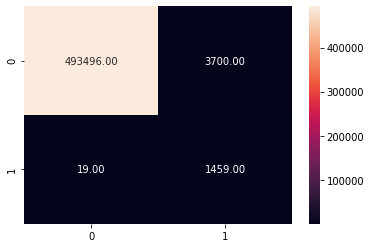

In [62]:
# Validate the model 
non_logits_preds = [0 if x < 0.5 else 1 for x in df_pred[0]]
labels = test_set["target"]
labels = [float(x) for x in labels]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, non_logits_preds)

import seaborn as sns 
sns.heatmap(cm, annot=True, fmt="0.2f");